In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf

tf.__version__

2021-11-17 12:58:53.401913: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


'2.3.4'

In [6]:
train_dir = 'train' 
valid_dir = 'validation'

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 60, 
                                   shear_range = 0.2,
                                   zoom_range = 0.1, 
                                   horizontal_flip=True,
                                   fill_mode = 'nearest')
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (275,205),
                  batch_size = 16, 
                  class_mode = 'categorical') 


valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (275,205),
                  batch_size = 16,
                  class_mode = 'categorical')

Found 12000 images belonging to 6 classes.
Found 4800 images belonging to 6 classes.


In [1]:
from tensorflow.keras.applications import ResNet50

conv_base = ResNet50(weights = 'imagenet',
                  include_top = False,
                  input_shape = (275,205, 3))

In [2]:
print('conv_base 동결 후 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 후 훈련 가능 가중치의 종류: 212


In [9]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 275, 205, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 281, 211, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 138, 103, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 138, 103, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [4]:
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'conv3_block1_1_conv':
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [5]:
print('conv_base 동결 후 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 후 훈련 가능 가중치의 종류: 168


In [12]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

In [13]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)

model.add(GlobalAveragePooling2D())
model.add(BatchNormalization()) # 추가
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(6, activation = 'softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 9, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 24,121,990
Trainable params: 23,837,958
Non-trainable params: 284,032
______________________________________

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

filename = '/1117_resnet16_acc_{epoch:02d}_{val_accuracy:.5f}.h5'

checkpoint1 = ModelCheckpoint(filename,          
                             monitor='val_accuracy',  
                             verbose=1,           
                             save_best_only=True,  
                             mode='max'          
                            )

checkpoint2 = ReduceLROnPlateau(monitir = 'val_loss',
                               factor = 0.5,
                               patience = 3,
                               verbose = 1,
                               mode = 'min'
                               )

checkpoint = [checkpoint1, checkpoint2]
#checkpoint = checkpoint1

In [17]:
from tensorflow.keras import optimizers

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.0001),
              metrics = ['accuracy'])

In [18]:
%%time

face = model.fit(train_generator,
                epochs = 50,
                validation_data = valid_generator,
                validation_steps = 300,
                callbacks = checkpoint )

Epoch 1/50


2021-11-17 12:59:27.314262: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-17 12:59:27.681494: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


750/750 [==============================] - ETA: 0s - loss: 1.6872 - accuracy: 0.4140
Epoch 00001: val_accuracy improved from -inf to 0.51833, saving model to /home/lab02/1117_resnet16_acc_01_0.51833.h5
750/750 [==============================] - 314s 418ms/step - loss: 1.6872 - accuracy: 0.4140 - val_loss: 1.2689 - val_accuracy: 0.5183
Epoch 2/50
750/750 [==============================] - ETA: 0s - loss: 1.1973 - accuracy: 0.5718
Epoch 00002: val_accuracy improved from 0.51833 to 0.56333, saving model to /home/lab02/1117_resnet16_acc_02_0.56333.h5
750/750 [==============================] - 313s 417ms/step - loss: 1.1973 - accuracy: 0.5718 - val_loss: 1.2617 - val_accuracy: 0.5633
Epoch 3/50
750/750 [==============================] - ETA: 0s - loss: 1.0745 - accuracy: 0.6159
Epoch 00003: val_accuracy did not improve from 0.56333
750/750 [==============================] - 312s 416ms/step - loss: 1.0745 - accuracy: 0.6159 - val_loss: 1.2825 - val_accuracy: 0.5410
Epoch 4/50
750/750 [======

Epoch 28/50
750/750 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.8670
Epoch 00028: val_accuracy did not improve from 0.72875
750/750 [==============================] - 325s 434ms/step - loss: 0.3667 - accuracy: 0.8670 - val_loss: 0.9234 - val_accuracy: 0.7248
Epoch 29/50
750/750 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8652
Epoch 00029: val_accuracy did not improve from 0.72875
750/750 [==============================] - 326s 435ms/step - loss: 0.3655 - accuracy: 0.8652 - val_loss: 0.9269 - val_accuracy: 0.7244
Epoch 30/50
750/750 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.8663
Epoch 00030: val_accuracy did not improve from 0.72875
750/750 [==============================] - 325s 434ms/step - loss: 0.3613 - accuracy: 0.8663 - val_loss: 0.9338 - val_accuracy: 0.7240
Epoch 31/50
750/750 [==============================] - ETA: 0s - loss: 0.3531 - accuracy: 0.8712
Epoch 00031: val_accuracy did not improve 

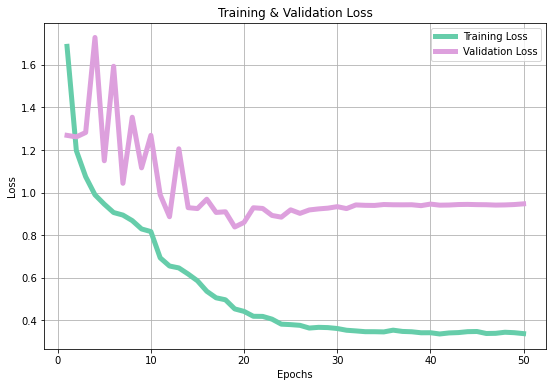

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, len(face.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, face.history['loss'], color = 'mediumaquamarine',linewidth=5)
plt.plot(epochs, face.history['val_loss'], color = 'plum',linewidth=5)

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
#plt.savefig('/resnet16_loss.jpg')

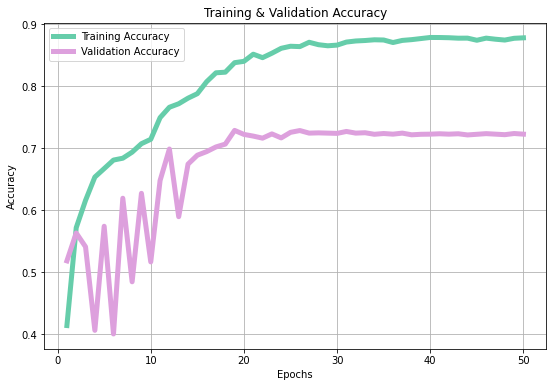

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, len(face.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, face.history['accuracy'], color = 'mediumaquamarine',linewidth=5)
plt.plot(epochs, face.history['val_accuracy'],  color = 'plum',linewidth=5)

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()
#plt.savefig('/resset16_acc.jpg')

In [21]:
#model.save('/resnet16_final.h5')